# Summary

Extending the analysis by adding a new model. This approach is
roughly equivalent to choosing a number of stars by random. I'm
not sure how much we can debug this model, etc., before the paper
is due. It seems like the authors of the paper we're replicating
chose to use a continuous dependent variable and transformations
to move away from what we're seeing here... even though their
approach has a very academic outcome. 


I'm pretty much trying to replicate homework 8a and 8b using
our Yelp dataset and the features from the paper.

Let me know what you think. Thanks, Tyler.


# Dependencies

In [1]:
import itertools
from itertools import cycle

import graphviz
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             classification_report, roc_curve,
                             roc_auc_score, confusion_matrix, 
                             precision_recall_curve, average_precision_score)

%matplotlib inline

# Helper Functions

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Reference:
      http://scikit-learn.org/stable/auto_examples/
         model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Load Data

In [3]:
X_train = pd.read_parquet("X_train_spec.parquet", engine="pyarrow")
y_train = pd.read_parquet("y_train_spec.parquet", engine="pyarrow")
y_train.head()

,stars
4553573,4
183980,5
5202315,5
720790,2
3136567,5


In [4]:
X_test = pd.read_parquet("X_test_spec.parquet", engine="pyarrow")
y_test = pd.read_parquet("y_test_spec.parquet", engine="pyarrow")

In [5]:
y_train['stars'].replace({1:1, 2:1, 3:1, 4:5, 5:5}, inplace=True)
y_test['stars'].replace({1:1, 2:1, 3:1, 4:5, 5:5}, inplace=True)

# Features

In [6]:
X_train = X_train[['uRate', 'bRate', 'rCount', 'tlen', 'tpol', 'tsub', 'uAvg', 'bAvg']]
X_test = X_test[['uRate', 'bRate', 'rCount', 'tlen', 'tpol', 'tsub', 'uAvg', 'bAvg']]

# Generic Analysis

In [15]:
clf = tree.DecisionTreeClassifier(class_weight="balanced")

In [16]:
clf = clf.fit(X_train, y_train)

In [17]:
pred = clf.predict(X_test)

In [18]:
clf.score(X_test, y_test)

0.5532389678748973

In [19]:
print("Accuracy:", round(accuracy_score(y_test, pred), 2))

Accuracy: 0.55


In [20]:
precision = precision_score(y_test, pred, average="macro")
print('Precision value: {0:0.2f}'.format(precision))

recall = recall_score(y_test, pred, average="macro")
print('Recall value: {0:0.2f}'.format(recall))

Precision value: 0.50
Recall value: 0.50


In [21]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          1       0.34      0.34      0.34    579558
          5       0.66      0.66      0.66   1143954

avg / total       0.55      0.55      0.55   1723512



Confusion matrix, without normalization
[[195995 383563]
 [386435 757519]]


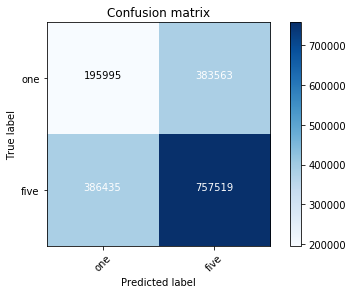

In [22]:
class_names = ["one", "five"]
cnf_matrix = confusion_matrix(y_test, pred)

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

# Implementing under-sampling due to imbalanced classes

Reference [imblearn](http://contrib.scikit-learn.org/imbalanced-learn/stable/install.html), a scikit-learn contribution module.

In [30]:
from collections import Counter

rus = RandomUnderSampler(random_state=42)
print('Original dataset shape {}'.format(Counter(y_train['stars'])))
y_test.head()
X_res, y_res = rus.fit_sample(X_train, y_train)
X_res_test, y_res_test = rus.fit_sample(X_test, y_test)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({5: 1613568, 1: 822094})


C:\Users\Kuebix\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Resampled dataset shape Counter({1: 822094, 5: 822094})


In [31]:
clf_with_us = tree.DecisionTreeClassifier(class_weight="balanced", random_state=0, max_depth=10)

In [32]:
clf_with_us = clf_with_us.fit(X_res, y_res)

In [33]:
pred_with_us = clf.predict(X_res_test)

In [34]:
clf_with_us.score(X_res_test, y_res_test)

0.4997429075260802

In [36]:
print(classification_report(y_res_test, pred_with_us))

             precision    recall  f1-score   support

          1       0.50      0.34      0.40    579558
          5       0.50      0.66      0.57    579558

avg / total       0.50      0.50      0.49   1159116



Confusion matrix, without normalization
[[195995 383563]
 [195585 383973]]


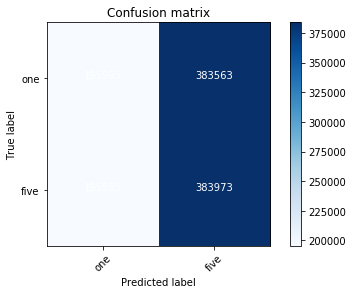

In [38]:
class_names = ["one", "five"]
cnf_matrix = confusion_matrix(y_res_test, pred_with_us)

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

## Ridge Regression

In [16]:
clf1 = Ridge(alpha=1.0)
clf1.fit(X_train, y_train) 


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [21]:
pred1 = clf1.predict(X_test)

In [44]:
mean_squared_error(y_test, pred1)

1.8915512088763033

## Ridge regression with undersampling

In [39]:
pipe1 = Pipeline([
    ('rus', RandomUnderSampler(random_state=0)), 
    ('classifier', Ridge(alpha=1.0))
])

In [40]:
pipe1.fit(X_train, y_train)

C:\Users\Kuebix\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('rus', RandomUnderSampler(random_state=0, ratio='auto', replacement=False,
          return_indices=False)), ('classifier', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [41]:
pred2 = pipe1.predict(X_test)

In [43]:
mean_squared_error(y_test, pred2)

2.4488519489969898